# Apply spaTrack on spatial data of Intrahepatic cholangiocarcinoma cancer

In [1]:
import sys
sys.path.append('/hwfssz1/ST_SUPERCELLS/P21Z10200N0134/USER/huangke2/27.spatial.trajectory/12.SpaTrack/03.code/spaTrack-main/spaTrack/')

Rebuilding lineages of tumorigenesis can improve us understand the deterioration and developmental process of primary tumors and describe the behaviors of malignant cells.Considering the heterozygosity and complex of malignant cells, it is possible that tumors originate from multiple starte regions. Here, we performed spaTrack to rebuild the diverse lineages of ICC tumorigenesis by spatial transcriptomics data of ICC tumor section. This notebook uses the intrahepatic cholangiocarcinoma cancer (ICC) ST data to show how spaTrack infer trajectories when data has multiple origins. Spatial transcriptomics data of ICC can be download from the link ([click here](https://github.com/yzf072/spaTrack/blob/main/spaTrack/example.data/))

In [2]:
#import spaTrack as spt
import single_time as spt
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")
sc.settings.verbosity = 0
plt.rcParams['figure.dpi'] = 200 #分辨率

## 1. Prepare ICC adata

Convert tsv files to scanpy adata (the tsv file format was described in 01 notebook)

In [3]:
adata = sc.read("/hwfssz1/ST_SUPERCELLS/P21Z10200N0134/USER/huangke2/27.spatial.trajectory/12.SpaTrack/04.ICC/01.ICC.trans/05.ICC.origin.trans.exp.data/P.slid.filter/ICC.primary.ST.exp_count.tsv", cache=True)
anno = pd.read_table("/hwfssz1/ST_SUPERCELLS/P21Z10200N0134/USER/huangke2/27.spatial.trajectory/12.SpaTrack/04.ICC/01.ICC.trans/05.ICC.origin.trans.exp.data/P.slid.filter/ICC.primary.ST.annot.tsv")

adata.obs.index = anno["ID"].values
adata.obs["cluster"] = anno["cluster"].values
adata.obsm["X_spatial"] = anno[["x", "y"]].values


Perform basic preprocessing and visualize spatial data

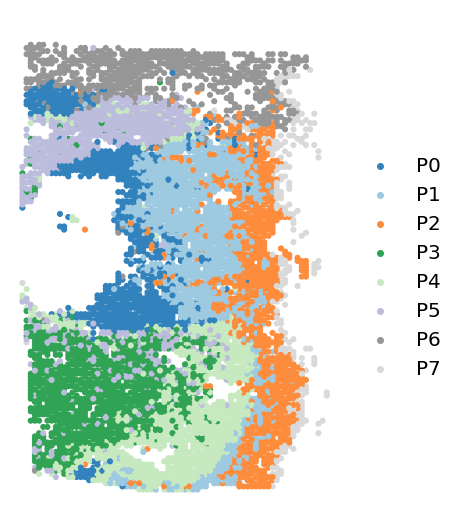

In [7]:
sc.pp.filter_genes(adata,min_cells=30)
sc.pp.normalize_total(adata,target_sum=1e4)
sc.pp.log1p(adata)
fig, axs = plt.subplots(figsize=(6, 9))
ax = sc.pl.embedding(adata,  basis='X_spatial',show=False,color='cluster',ax=axs,frameon=False,title=' ',palette='tab20c',size=150, legend_fontsize=20)

## 2. Choose start cells

In order to identify potential start regions, multiple factors were considered. In cases where prior knowledge and biological evidence were not available to support the selection of start cells, we suggested using G2M score and the expression of stemness markers. 

In our analysis of ICC tumor section data, the P0 cluster showed relatively high expression of cancer stemness markers and higher G2M score, which represents higher cell proliferation compared with other clusters, thus was selected as start regions.

Since the P0 cluster was distributed across four distinct regions, we used the k-means method with a cluster number of 4 to identify the aggregation points of the P0 cluster. Neighbor cells were then taken as start cells for the trajectory inference.

kmean cluster centers:
[  866.37931034 16618.10344828]
[ 2811.91135734 10332.4099723 ]
[ 2404.26356589 14189.92248062]
[1654.16666667 4750.        ]


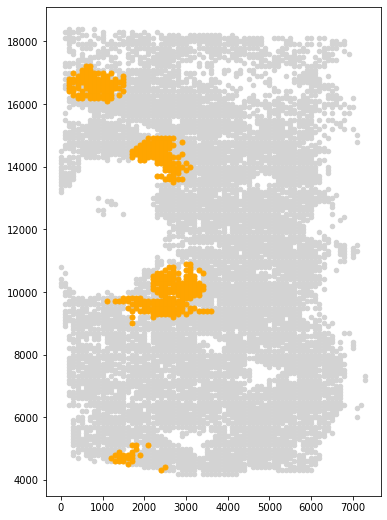

In [9]:
fig, axs = plt.subplots(figsize=(6, 9))
start_cells=spt.set_start_cells(adata,select_way='cell_type',partition=True,cell_type='P0',n_neigh=100,n_clusters=4)

plt.scatter(adata.obsm['X_spatial'][:,0],adata.obsm['X_spatial'][:,1],c='#D3D3D3',s=20)
plt.scatter(adata.obsm['X_spatial'][start_cells][:,0],adata.obsm['X_spatial'][start_cells][:,1],c='orange',s=25)

## 3. Calculate cell transition probability

Calculate cell transition probability based on gene expression matrix and cell spatial coordinate

In [10]:
adata.obsp['trans']=spt.get_ot_matrix(adata,data_type='spatial')

X_pca is not in adata.obsm, automatically do PCA first.


## 4. Caculate cell pseudotime

Assign a pseudo-time value to each cell

In [11]:
adata.obs['ptime']=spt.get_ptime(adata,start_cells)

## 5. Calculate vector field velocity.

calculate vector field velocity by averaging the velocities of each cell and its neighbors:

In [12]:
adata.uns['E_grid'],adata.uns['V_grid']=spt.get_velocity(adata,basis='spatial',n_neigh_pos=100)

## 6. Plot results

visualization of cell pseudotime and inferred cell trajectory.

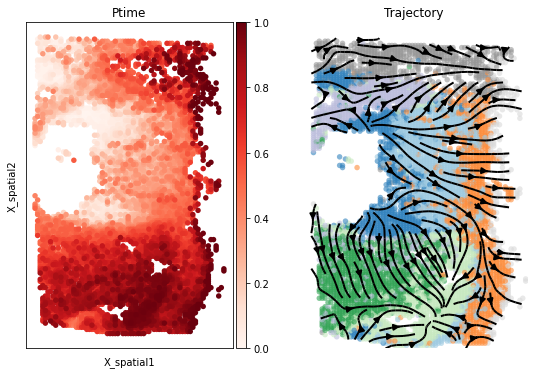

In [13]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(9, 6))

sc.pl.embedding(adata, basis='X_spatial', color='ptime', show=False, ax=axs[0], color_map='Reds', title='Ptime',size=120)

vf_velocity = sc.pl.embedding(adata, basis='X_spatial', show=False, ax=axs[1],color='cluster', legend_loc=None, frameon=False, title='Trajectory', alpha=0.6, size=120)
vf_velocity.streamplot(adata.uns['E_grid'][0], adata.uns['E_grid'][1], adata.uns['V_grid'][0], adata.uns['V_grid'][1], color='black', linewidth=2,density=1.2,arrowsize=1.2)

## 7. Downstream analysis

In order to apply the LAP algorithm to spatial transcriptomics data, we need to reconstruct the grid-level vector field into cell-level data. This is done by interpolating the vector field values from the grid points to the cell locations, which enables us to calculate the velocity vectors for individual cells. The resulting cell-level vector field is then used as input to the LAP algorithm to infer the optimal transition path between the chosen start and end points

In [14]:
VecFld=spt.VectorField(adata,basis='spatial')

### 7.1 Least Action Path (LAP)

Select the start point and the end point across the direction of trajectory

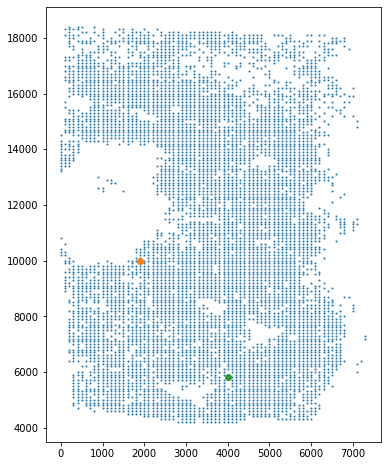

In [15]:

fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(6, 8))


LAP_start_point=[1900,10000]
LAP_end_point=[4000,5800]
LAP_start_cell=spt.utils.nearest_neighbors(LAP_start_point,adata.obsm['X_spatial'])[0][0]
LAP_end_cell=spt.utils.nearest_neighbors(LAP_end_point,adata.obsm['X_spatial'])[0][0]

plt.scatter(*adata.obsm["X_spatial"].T,s=1)
plt.scatter(*adata[LAP_start_cell].obsm['X_spatial'].T)
plt.scatter(*adata[LAP_end_cell].obsm['X_spatial'].T)

Get the neighbors according to the spatial location

In [16]:
sc.pp.neighbors(adata,use_rep='X_spatial',key_added='X_spatial',n_neighbors=100)

Calculate the least action path between given start cell and end cell

In [17]:
lap=spt.least_action(adata,
    init_cells=adata.obs_names[LAP_start_cell],
    target_cells=adata.obs_names[LAP_end_cell],
    vecfld=VecFld,
    basis='spatial',
    adj_key='X_spatial_distances',
    EM_steps=5,
    n_points=20
)

Visualization of LAP and color bar represents pseudotime

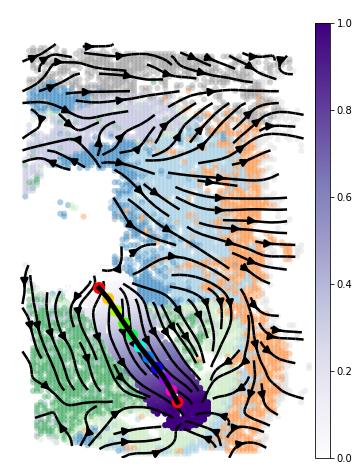

In [23]:
LAP_ptime,LAP_nbrs=spt.lap.map_cell_to_LAP(adata)
sub_adata=adata[LAP_nbrs,:]
sub_adata.obs['ptime']=LAP_ptime
sub_adata=sub_adata[np.argsort(sub_adata.obs["ptime"].values), :].copy()

fig, ax = plt.subplots(figsize=(6,8))
plt.axis('off')
ax = sc.pl.embedding(adata,  basis='X_spatial',color='cluster',show=False,ax=ax,frameon=False,legend_loc=None,alpha=0.4,size=150)
ax.streamplot(adata.uns['E_grid'][0], adata.uns['E_grid'][1], adata.uns['V_grid'][0], adata.uns['V_grid'][1],density=1.2,color='black',linewidth=2.5,arrowsize=1.5,minlength=0.1,maxlength=0.8)
ax = spt.plot_least_action_path(adata,basis='spatial',ax=ax,point_size=120,linewidth=5)
sc.pl.embedding(sub_adata, basis='X_spatial',ax=ax, color="ptime", cmap="Purples",frameon=True,size=150,title=' ')

### 7.2 Pseudotime-dependent genes on LAP

Choose cell type of interest on LAP and filter genes with high variability which larger than minimum expression proportion.

In [25]:
sub_adata_path=sub_adata[sub_adata.obs['cluster'].isin(['P0','P3','P4'])]
sub_adata_path=spt.filter_gene(sub_adata_path,min_exp_prop=0.1,hvg_gene=5000)

cluter ordered by ptime :  ['P0', 'P3', 'P4']
Cell number	661
Gene number	1454


To investigate the relationship between gene expression changes and pseudotime values, we applied the generalized additive model (GAM). This allowed us to filter for pseudotime-dependent genes based on their model fit (R2) and false discovery rate (FDR). Only genes that showed significant associations with pseudotime values were selected as pseudotime-dependent genes.

In [26]:
df_res  = spt.ptime_gene_GAM(sub_adata_path,core_number=5)

Genes number fitted by GAM model:   1454


In [27]:
df_sig_res = df_res.loc[(df_res['model_fit']>0.15) & (df_res['fdr']<0.05)]
sort_exp_sig = spt.order_trajectory_genes(sub_adata_path,df_sig_res,cell_number=20)

Finally selected 46 genes.


Use heatmap to display pseudotime-dependent genes

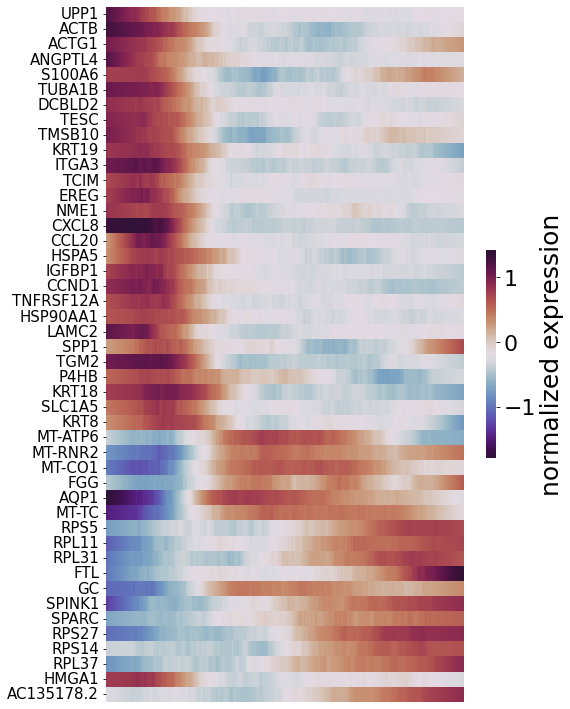

In [28]:
spt.plot_trajectory_gene_heatmap(sort_exp_sig,smooth_length=100,gene_label_size=15,cmap_name='twilight_shifted')

Show example of pseudotime-dependent genes

<AxesSubplot: title={'center': 'AQP1'}, xlabel='ptime', ylabel='expression'>

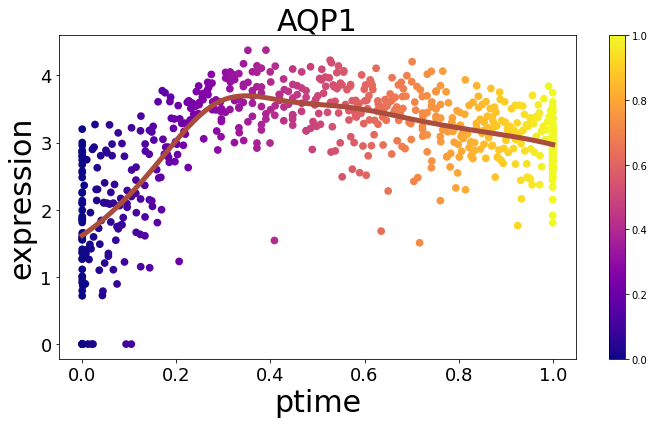

In [29]:
spt.plot_trajectory_gene(sub_adata_path,gene_name='AQP1',point_size=60)

<AxesSubplot: title={'center': 'TGM2'}, xlabel='ptime', ylabel='expression'>

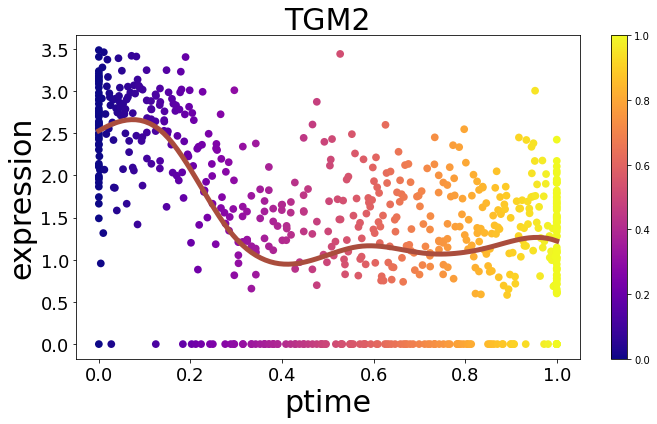

In [30]:
spt.plot_trajectory_gene(sub_adata_path,gene_name='TGM2',point_size=60)